In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

#  1. Load the text

(i) Use the appropriate url/address.

(ii). Drop Unnecessary features.

In [206]:
df = pd.read_csv(r"E:\kritsnam data\CWC-01.csv")
df.drop(columns = ['Flagged'], inplace = True)
df.head()

,Timestamp,Water Level(In mm)
0,2018-09-12 18:36:14,5645.0
1,2018-09-12 18:42:12,5646.0
2,2018-09-12 18:48:10,5642.0
3,2018-09-12 18:53:54,5650.0
4,2018-09-12 19:05:25,5650.0


# 2. Exploratory/Preliminary Plot

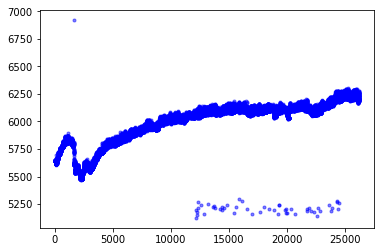

In [207]:
plt.plot(df['Water Level(In mm)'], 'b.', alpha = 0.5)

# 3. The Algorithm 

# (i). For Historical data

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large d_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

$\large\hat{d_t} = \frac{\sum_{i = t-k}^{t-1} w_i d_i + \sum_{i = t+1}^{t+k} w_i d_i}{\sum_{i = t-k}^{t-1} w_i + \sum_{i = t+1}^{t+k} w_i }$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is the upper $\alpha$ point of a t distribution with 2k-1 degrees of freedom and $\alpha$ is the level of significance.



 If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$

In [208]:
T = df.iloc[:, 1].values
def feature_extract(i, k, alpha):
    d_original = T[i]
    window_left = T[i-k:i]
    window_right = T[i:i+k]
    wt_right = np.arange(k, 0, -1)
    wt_left = np.arange(1, k+1, 1)
    d_estimate = ((window_left*wt_left).sum() + (window_right*wt_right).sum())/(wt_left.sum()+wt_right.sum())
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(np.hstack((window_left, window_right)))
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(np.hstack((window_left, window_right)))
    state = 0
    if (d_original<pci_l) or (d_original>pci_r):
        state = 1    
    dat = [d_estimate, pci_l, pci_r, state]
    return dat
def fin_calc(k, alpha):
    l = np.arange(k, len(T)-k, dtype = np.int64)
    fin = map(feature_extract, l, [k]*(len(T)-2*k), [alpha]*(len(T)-2*k))
    df2 = pd.DataFrame(list(fin), columns = ['Estimated', 'Lower', 'Upper', 'Status'], index = range(k, len(T)-k))
    return df2

In [209]:
k = 6 
alpha = 0.97
df2 = fin_calc(6, 0.97)

In [210]:
df2.head()

,Estimated,Lower,Upper,Status
6,5644.428571,5635.529120,5653.328023,0
7,5643.500000,5634.186739,5652.813261,0
8,5642.476190,5632.828215,5652.124166,0
9,5641.571429,5631.923453,5651.219404,0
10,5640.857143,5632.480021,5649.234265,0


In [211]:
df2 = pd.merge(df, df2, 'right', left_index = True, right_index = True)

In [212]:
df2.head()

,Timestamp,Water Level(In mm),Estimated,Lower,Upper,Status
6,2018-09-12 19:16:53,5642.0,5644.428571,5635.529120,5653.328023,0
7,2018-09-12 19:22:35,5645.0,5643.500000,5634.186739,5652.813261,0
8,2018-09-12 19:29:07,5638.0,5642.476190,5632.828215,5652.124166,0
9,2018-09-12 19:34:52,5637.0,5641.571429,5631.923453,5651.219404,0
10,2018-09-12 19:40:37,5642.0,5640.857143,5632.480021,5649.234265,0


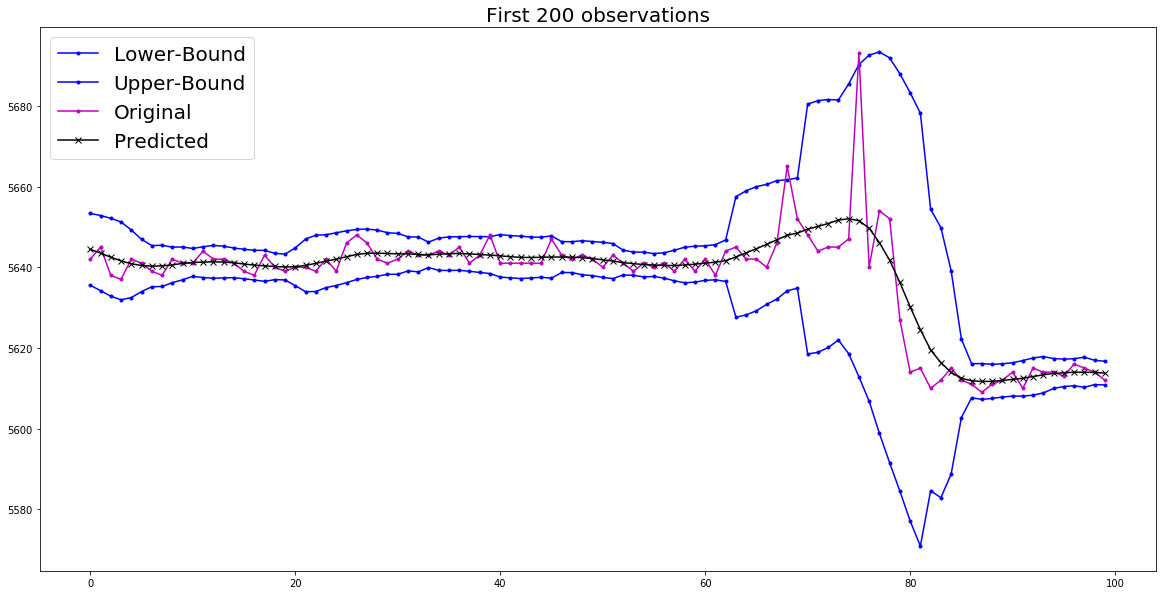

In [213]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(df2['Lower'].values[0:100], 'b.-', label = "Lower-Bound")
ax.plot(df2['Upper'].values[0:100], 'b.-', label = "Upper-Bound")
ax.plot(df2['Water Level(In mm)'].values[0:100], 'm.-', label = "Original")
ax.plot(df2['Estimated'].values[0:100], 'k-x', label = "Predicted")
ax.set_title('First 200 observations', size = 20)
ax.legend(loc = "upper left", fontsize = 20)

Text(0.5,0,'$x_t$')

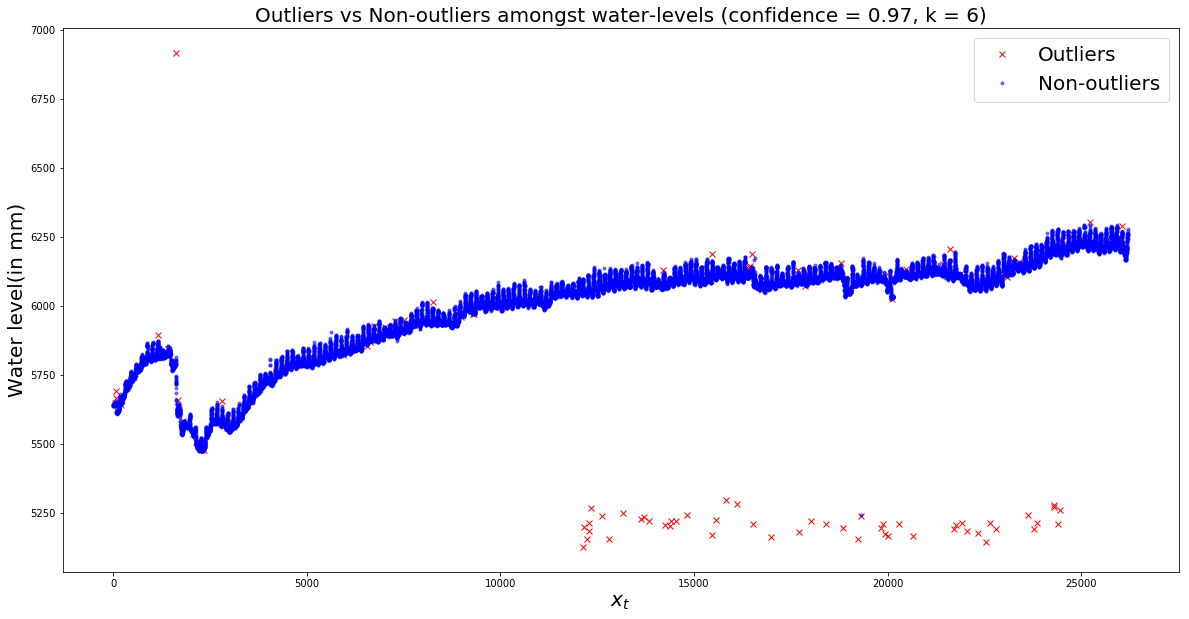

In [214]:
fig2 = plt.figure(figsize = (20, 10))
ax = fig2.add_subplot(111)
ax.plot(df2[df2['Status']==1]['Water Level(In mm)'], 'rx', alpha = 1, label = 'Outliers')
ax.plot(df2[df2['Status']==0]['Water Level(In mm)'], 'b.', alpha = 0.5, label = 'Non-outliers')
ax.legend(loc = 1, fontsize = 20)
ax.set_title('Outliers vs Non-outliers amongst water-levels (confidence = 0.97, k = 6)', size = 20)
ax.set_ylabel('Water level(in mm)', size = 20)
ax.set_xlabel('$x_t$', size = 20)

# (ii). For new observations.

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large d_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

$\large\hat{d_t} = \frac{\sum_{i = t-2k}^{t-1} w_i d_i}{\sum_{i = t-2k}^{t-1} w_i}$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is the upper $\alpha$ point of a t distribution with 2k-1 degrees of freedom and $\alpha$ is the level of significance.

If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$

In [177]:
def new_obs_pred(d_obs, k, alpha):
    d_original = d_obs[1]
    window_left = df.iloc[:, 1].values[len(df)-2*k:len(df)]
    wt_left = np.arange(1, 2*k+1)
    d_estimate = sum(window_left*wt_left)/sum(wt_left)
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    state = 0.0
    if (d_original<pci_l) or (d_original>pci_r):
        state = 1.0    
    dat = [d_obs[0], d_original, d_estimate, pci_l, pci_r, state]
    return dat



In [215]:
ob = new_obs_pred(d_obs, 6, 0.97)
ob

['2019-04-02 18:27:08',
 6239.0,
 6234.5,
 6200.930405752981,
 6268.069594247019,
 0.0]

In [216]:
df2 = df2.append(pd.Series(ob, index = df2.columns), ignore_index = True)
df.tail(5)

,Timestamp,Water Level(In mm)
26199,2019-04-02 18:37:20,6232.0
26200,2019-04-02 18:47:32,6233.0
26201,2019-04-02 18:57:44,6231.0
26202,2019-04-02 19:07:56,6224.0
26203,2019-04-02 19:18:08,6218.0
